# Gas usage by component and opcode - exploratory analysis

#### Maria Silva, April 2025

## 1. Imports and settings

Let's start by importing the necessary libraries and setting up some directories and files.


In [1]:
import os
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle

import warnings

warnings.filterwarnings("ignore")

In [2]:
# plotting theme
sns.set_theme(
    style="whitegrid", palette="Set2", rc={"figure.dpi": 500, "axes.titlesize": 15}
)

In [3]:
# Main directories and files
current_path = os.getcwd()
repo_dir = os.path.abspath(os.path.join(current_path, ".."))
data_dir = os.path.join(repo_dir, "data")
op_files_dir = os.path.join(data_dir, "aggregated_opcodes_v2", "*", "file.parquet")

## 2. Load data

Now, let's load the data. We will start by loading the opcodes used for blocks 22000000 to 22001999.

In [4]:
# Load parquet files with duckdb
query = f"""
SELECT block_height, tx_hash, op, op_gas_cost, op_gas_pair_count
FROM read_parquet(
    '{op_files_dir}', 
    hive_partitioning=True, 
    filename=True,
    file_row_number=True,
    union_by_name=True
    )
WHERE block_height BETWEEN 22000000 AND 22001999;
"""
raw_usage_df = duckdb.connect().execute(query).fetchdf()
# Print info
raw_usage_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13518730 entries, 0 to 13518729
Data columns (total 5 columns):
 #   Column             Dtype  
---  ------             -----  
 0   block_height       int64  
 1   tx_hash            object 
 2   op                 object 
 3   op_gas_cost        float64
 4   op_gas_pair_count  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 515.7+ MB


In [5]:
raw_usage_df["block_height"].agg(["min", "max"])

min    22000020
max    22001999
Name: block_height, dtype: int64

Note that we only have data starting at 22000020. Now, we can load the gas used per transaction.

In [6]:
# Load parquet file
tx_gas_usage_df = pd.read_parquet(
    os.path.join(data_dir, "tx_gas_usage_22000000_22006000.parquet")
)
# Clean up columns
tx_gas_usage_df = tx_gas_usage_df.drop(columns=["block_height"])
tx_gas_usage_df.columns = [
    "tx_hash",
    "tx_gas_cost",
    "tx_gas_limit",
    "tx_input_data_gas_cost",
    "is_contract_creation",
    "is_success",
]
# Print info
tx_gas_usage_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 937679 entries, 0 to 937678
Data columns (total 6 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   tx_hash                 937679 non-null  object
 1   tx_gas_cost             937679 non-null  int64 
 2   tx_gas_limit            937679 non-null  int64 
 3   tx_input_data_gas_cost  937679 non-null  int64 
 4   is_contract_creation    937679 non-null  int64 
 5   is_success              937679 non-null  object
dtypes: int64(4), object(2)
memory usage: 42.9+ MB


## 3. Process data

In [7]:
# Add total transaction gas
usage_df = raw_usage_df.merge(tx_gas_usage_df, on="tx_hash", how="left")
# Fix op_gas_cost for transactions with no opcodes
usage_df["op_gas_cost"] = np.where(
    (usage_df["op"].isin(["NO_TRACE", "RESPONSE_TOO_LARGE"]))
    & (usage_df["is_contract_creation"] == 0),
    usage_df["tx_gas_cost"] - usage_df["tx_input_data_gas_cost"] - 21000.0,
    usage_df["op_gas_cost"],
)
usage_df["op_gas_cost"] = np.where(
    (usage_df["op"].isin(["NO_TRACE", "RESPONSE_TOO_LARGE"]))
    & (usage_df["is_contract_creation"] == 1),
    usage_df["tx_gas_cost"] - usage_df["tx_input_data_gas_cost"] - 53000.0,
    usage_df["op_gas_cost"],
)
# Clean up repeated opcodes
usage_df["op"] = np.where(usage_df["op"].str.startswith("DUP"), "DUP", usage_df["op"])
usage_df["op"] = np.where(usage_df["op"].str.startswith("SWAP"), "SWAP", usage_df["op"])
usage_df["op"] = np.where(
    (usage_df["op"].str.startswith("PUSH")) & (usage_df["op"] != "PUSH0"),
    "PUSH",
    usage_df["op"],
)
# Compute total gas cost for opcode
usage_df["op_total_gas_cost"] = usage_df["op_gas_cost"] * usage_df["op_gas_pair_count"]
# Print info
usage_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13518730 entries, 0 to 13518729
Data columns (total 11 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   block_height            int64  
 1   tx_hash                 object 
 2   op                      object 
 3   op_gas_cost             float64
 4   op_gas_pair_count       int64  
 5   tx_gas_cost             int64  
 6   tx_gas_limit            int64  
 7   tx_input_data_gas_cost  int64  
 8   is_contract_creation    int64  
 9   is_success              object 
 10  op_total_gas_cost       float64
dtypes: float64(2), int64(6), object(3)
memory usage: 1.1+ GB


In [8]:
# Aggregate costs by transaction
comp_df = (
    usage_df.groupby(["block_height", "tx_hash"])
    .agg(
        {
            "op_total_gas_cost": "sum",
            "tx_gas_cost": "first",
            "tx_input_data_gas_cost": "first",
            "is_contract_creation": "max",
        }
    )
    .reset_index()
)
# Set column names
comp_df.columns = [
    "block_height",
    "tx_hash",
    "op_gas_cost",
    "tx_gas_cost",
    "tx_input_data_cost",
    "is_contract_creation",
]
# Compute intrinsic cost
comp_df["intrinsic_base_cost"] = np.where(
    comp_df["is_contract_creation"] == 1, 53000.0, 21000.0
)
# Estimate gas refunds
comp_df["tx_gas_refund"] = (
    comp_df["op_gas_cost"]
    + comp_df["tx_input_data_cost"]
    + comp_df["intrinsic_base_cost"]
    - comp_df["tx_gas_cost"]
)
# Estimate intrinsic access cost
comp_df["intrinsic_access_cost"] = np.where(
    comp_df["tx_gas_refund"] < 0, -comp_df["tx_gas_refund"], 0.0
)
# Fix negative refunds
comp_df["tx_gas_refund"] = np.where(
    comp_df["tx_gas_refund"] < 0, 0.0, comp_df["tx_gas_refund"]
)
comp_df["tx_gas_refund_rate"] = comp_df["tx_gas_refund"] / (
    comp_df["op_gas_cost"]
    + comp_df["tx_input_data_cost"]
    + comp_df["intrinsic_base_cost"]
)
# Print head
comp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288411 entries, 0 to 288410
Data columns (total 10 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   block_height           288411 non-null  int64  
 1   tx_hash                288411 non-null  object 
 2   op_gas_cost            288411 non-null  float64
 3   tx_gas_cost            288411 non-null  int64  
 4   tx_input_data_cost     288411 non-null  int64  
 5   is_contract_creation   288411 non-null  int64  
 6   intrinsic_base_cost    288411 non-null  float64
 7   tx_gas_refund          288411 non-null  float64
 8   intrinsic_access_cost  288411 non-null  float64
 9   tx_gas_refund_rate     288411 non-null  float64
dtypes: float64(5), int64(4), object(1)
memory usage: 22.0+ MB


In [9]:
ignore_txs = comp_df[comp_df["tx_gas_refund_rate"] > 0.2]["tx_hash"].unique()

## 4. Gas usage by component

In [10]:
filtered_comp_df = comp_df[~comp_df["tx_hash"].isin(ignore_txs)]

### Component total contribution

In [11]:
melt_comp_df = filtered_comp_df.drop(
    columns=["tx_gas_cost", "is_contract_creation", "tx_gas_refund_rate"]
)
melt_comp_df.columns = [
    "block_height",
    "tx_hash",
    "Opcode",
    "Input data",
    "Intrinsic base",
    "Refund",
    "Intrinsic access",
]
melt_comp_df = melt_comp_df.melt(
    id_vars=["block_height", "tx_hash"], var_name="component", value_name="cost"
)

compt_stats = melt_comp_df.groupby("component")["cost"].agg(
    ["sum", "mean", "std", "median"]
)
compt_stats

sum           mean            std   median
component                                                            
Input data        1.101417e+09    3820.399016   41314.389314    608.0
Intrinsic access  7.474648e+08    2592.672097   42799.004583      0.0
Intrinsic base    6.063239e+09   21031.078845     996.775099  21000.0
Opcode            3.007261e+10  104310.498552  808531.500212  24501.0
Refund            1.546284e+09    5363.472204   15351.702765      0.0

In [12]:
compt_stats["sum"] / filtered_comp_df["tx_gas_cost"].sum()

component
Input data          0.030227
Intrinsic access    0.020513
Intrinsic base      0.166397
Opcode              0.825299
Refund              0.042435
Name: sum, dtype: float64

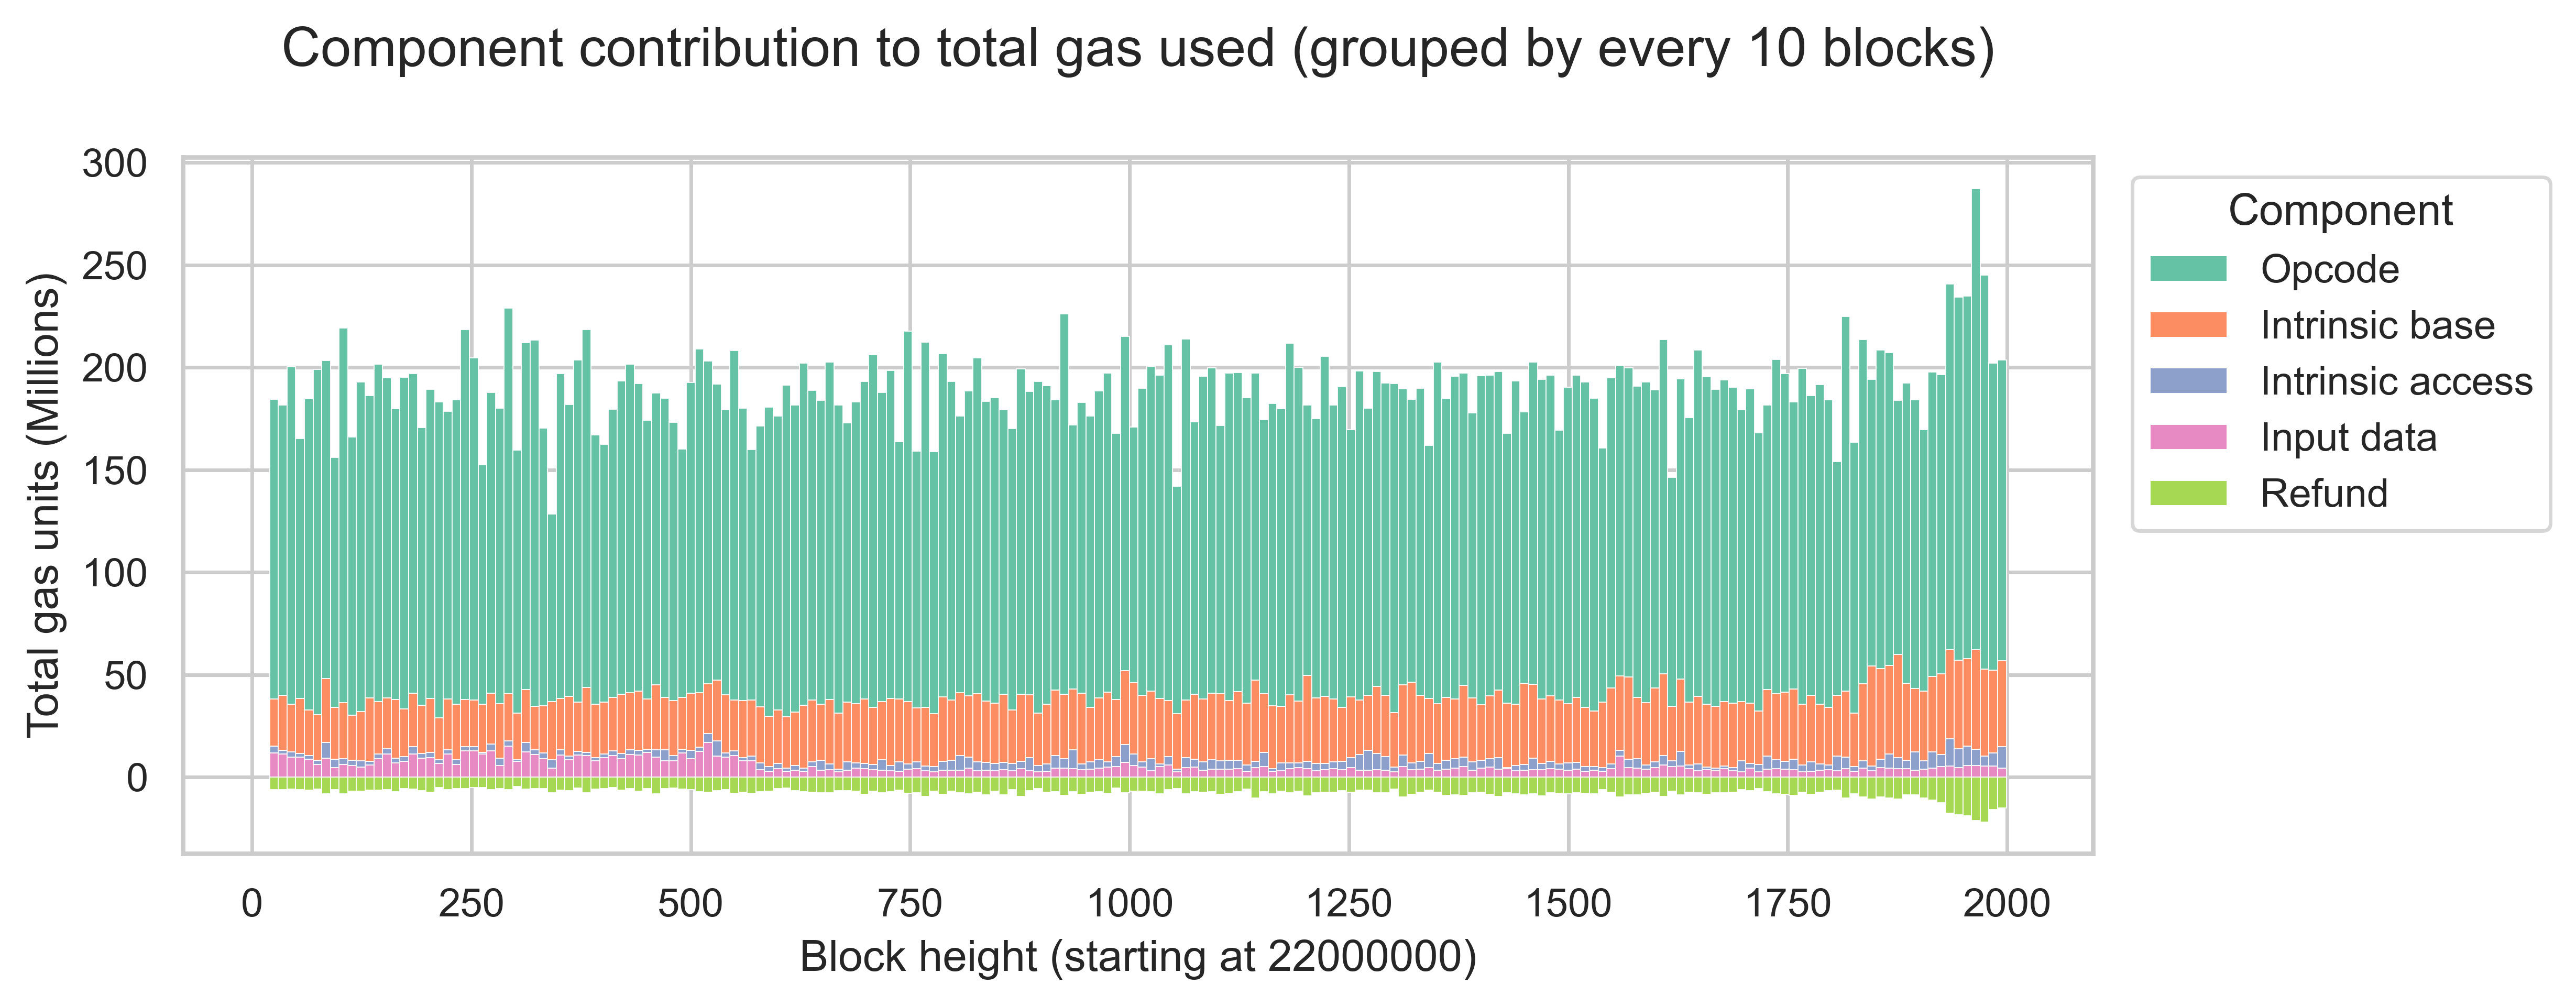

In [13]:
temp_df = melt_comp_df.groupby(["block_height", "component"])["cost"].sum() / 1_000_000
temp_df = temp_df.reset_index().sort_values("component", ascending=False)
temp_df["cost"] = np.where(
    temp_df["component"] == "Refund", -temp_df["cost"], temp_df["cost"]
)
temp_df["block_height"] = temp_df["block_height"] - 22000000

plt.figure(figsize=(10, 4))
ax1 = sns.histplot(
    temp_df[temp_df["component"] == "Refund"],
    x="block_height",
    weights="cost",
    color="#a6d854",
    bins=200,
    alpha=1.0,
)
ax2 = sns.histplot(
    temp_df[temp_df["component"] != "Refund"],
    x="block_height",
    weights="cost",
    hue="component",
    multiple="stack",
    bins=200,
    alpha=1.0,
)
legend_elements = [
    Rectangle((0, 0), 1, 1, facecolor="#66c2a5", label="Opcode"),
    Rectangle((0, 0), 1, 1, facecolor="#fc8d62", label="Intrinsic base"),
    Rectangle((0, 0), 1, 1, facecolor="#8da0cb", label="Intrinsic access"),
    Rectangle((0, 0), 1, 1, facecolor="#e78ac3", label="Input data"),
    Rectangle((0, 0), 1, 1, facecolor="#a6d854", label="Refund"),
]
ax1.legend(
    handles=legend_elements,
    bbox_to_anchor=(1.01, 1),
    loc="upper left",
    title="Component",
)
plt.title(
    "Component contribution to total gas used (grouped by every 10 blocks)", pad=25
)
plt.xlabel("Block height (starting at 22000000)")
plt.ylabel("Total gas units (Millions)")
plt.tight_layout()
plt.show()

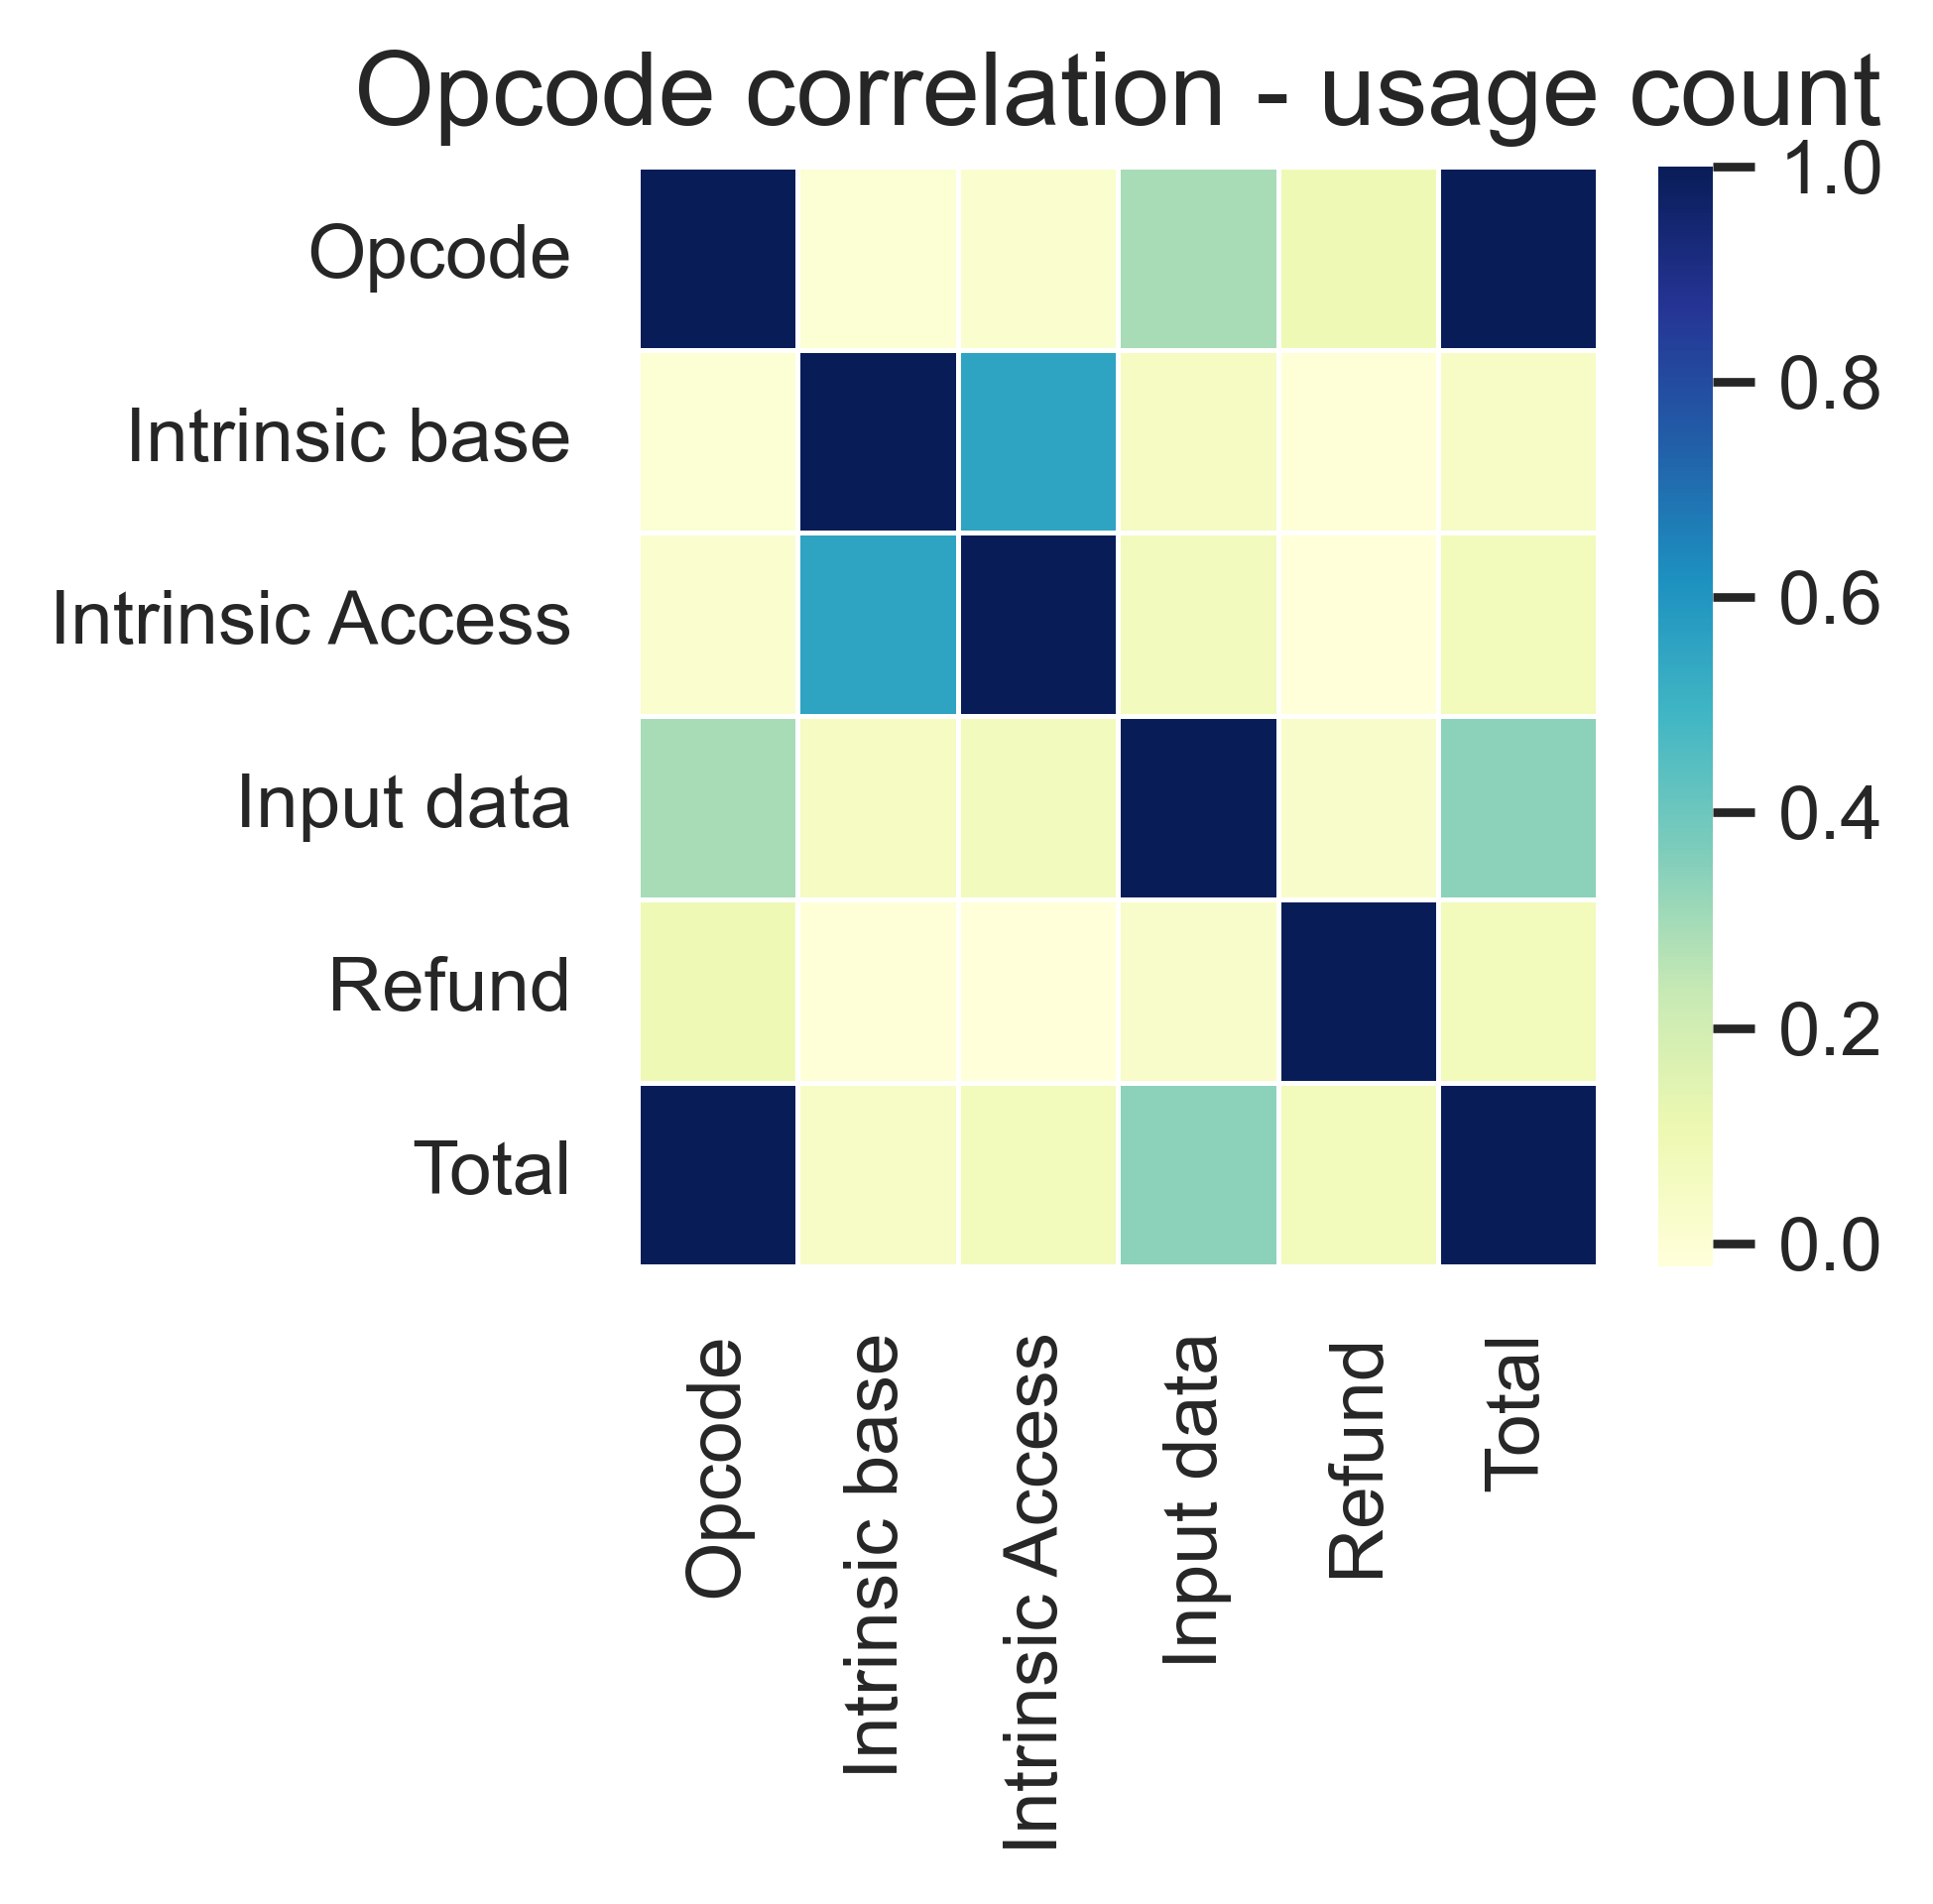

In [14]:
temp_df = comp_df.drop(
    columns=["block_height", "is_contract_creation", "tx_gas_refund_rate"]
).set_index("tx_hash")
temp_df.columns = [
    "Opcode",
    "Total",
    "Input data",
    "Intrinsic base",
    "Refund",
    "Intrinsic Access",
]
temp_df = temp_df[
    ["Opcode", "Intrinsic base", "Intrinsic Access", "Input data", "Refund", "Total"]
]
corr_mat = temp_df.corr()
plt.figure(figsize=(4, 4))
ax = sns.heatmap(corr_mat, cmap="YlGnBu", linewidths=0.5)
plt.title("Opcode correlation - usage count")
plt.tight_layout()
plt.show()

### Component percentage over transaction cost

In [15]:
melt_perc_comp_df = filtered_comp_df.drop(
    columns=["tx_gas_cost", "is_contract_creation", "tx_gas_refund_rate"]
)
cols = ["Opcode", "Input data", "Intrinsic base", "Refund", "Intrinsic access"]
melt_perc_comp_df.columns = ["block_height", "tx_hash"] + cols
melt_perc_comp_df[cols] = melt_perc_comp_df[cols].div(
    filtered_comp_df["tx_gas_cost"], axis=0
)
melt_perc_comp_df = melt_perc_comp_df.melt(
    id_vars=["block_height", "tx_hash"], var_name="component", value_name="cost_perc"
)

melt_perc_comp_df.groupby("component")["cost_perc"].agg(["mean", "std", "median"])

mean       std    median
component                                     
Input data        0.016546  0.031680  0.011123
Intrinsic access  0.007890  0.051065  0.000000
Intrinsic base    0.560127  0.359583  0.466273
Opcode            0.453699  0.376649  0.532306
Refund            0.038262  0.066970  0.000000

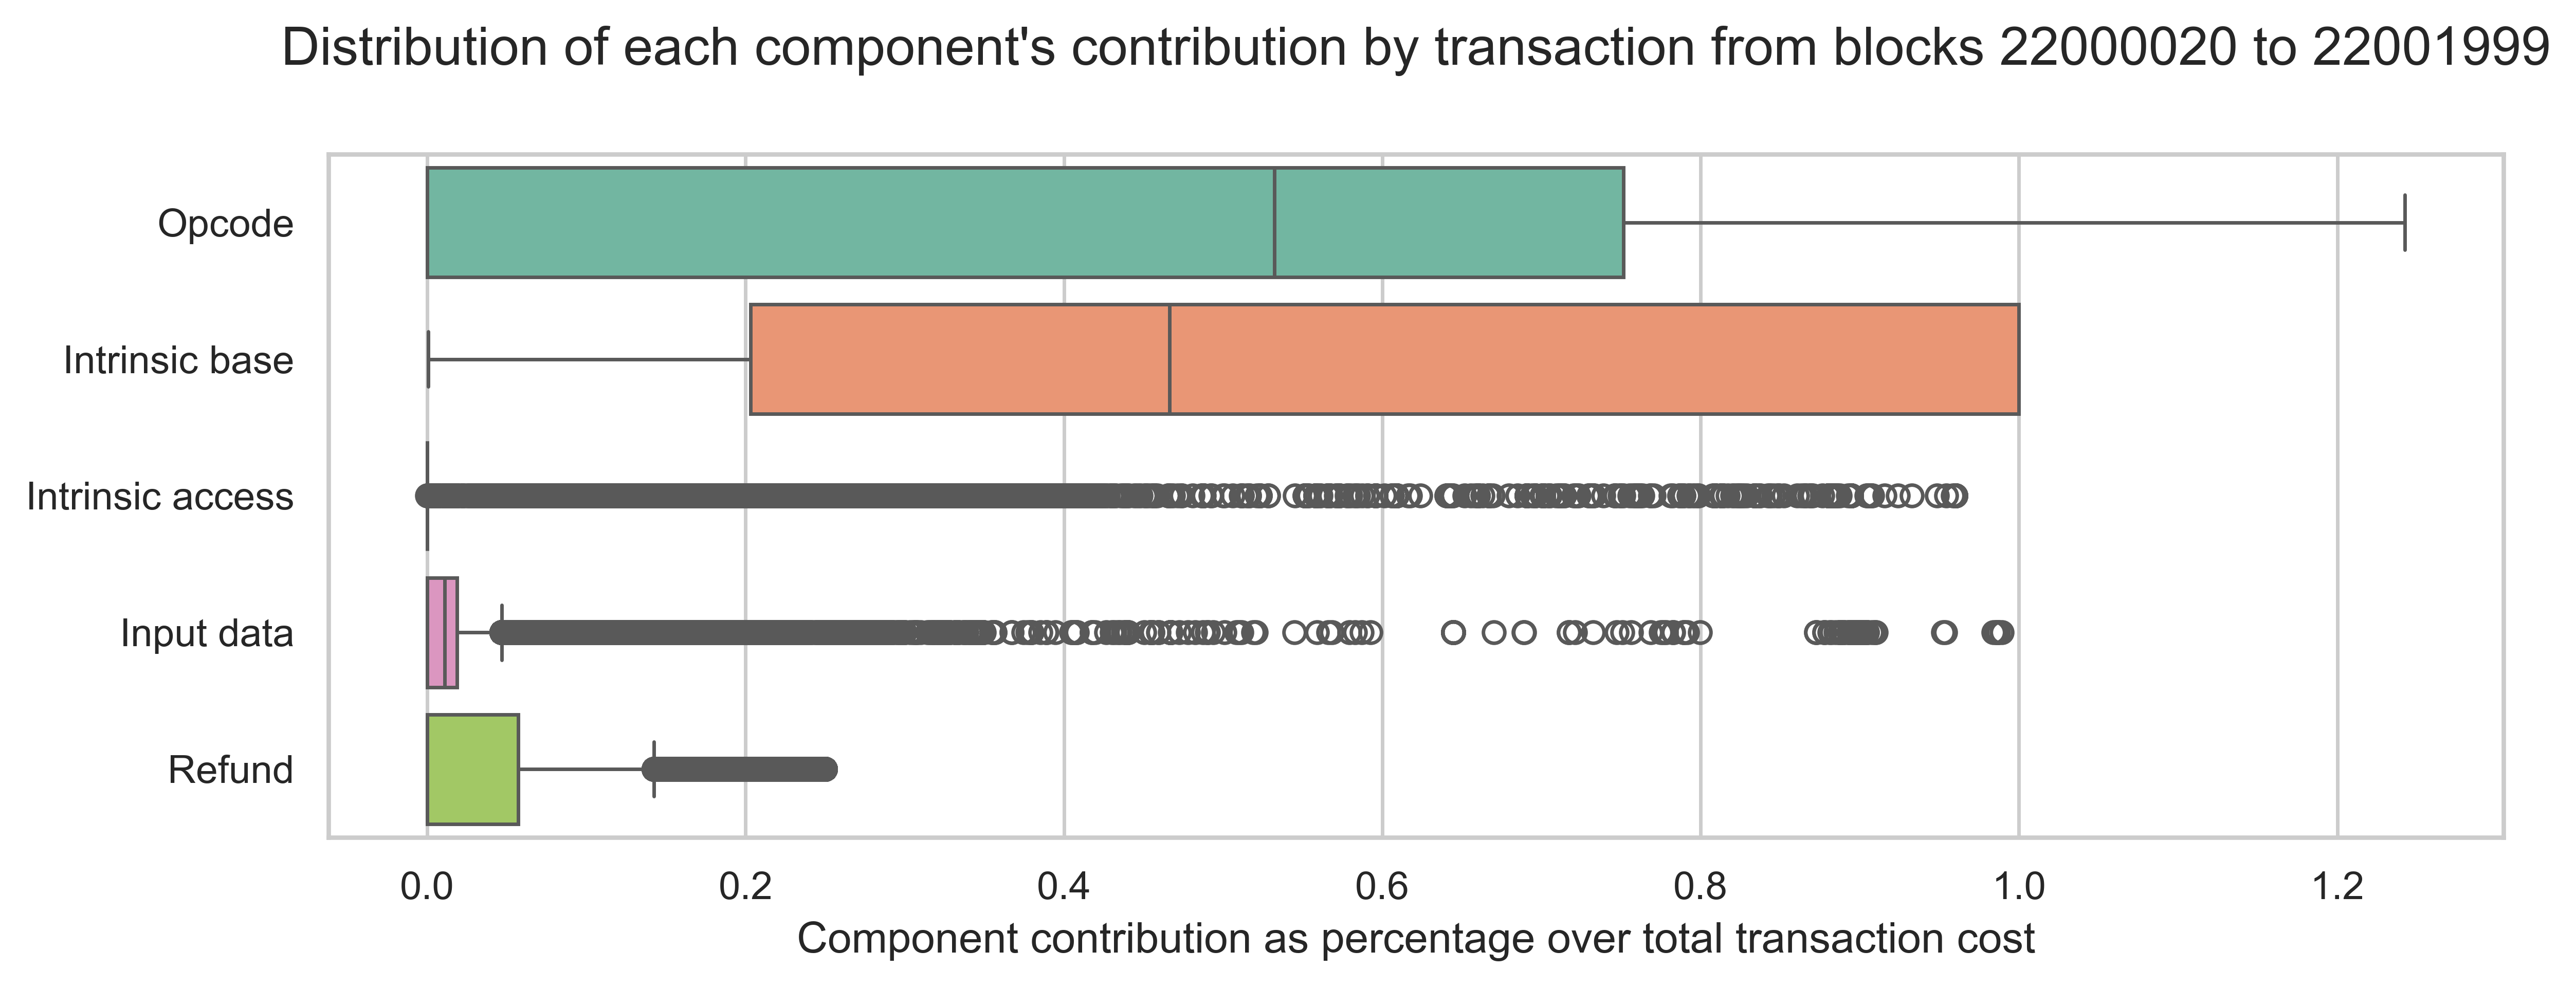

In [16]:
temp_df = melt_perc_comp_df[melt_perc_comp_df["component"] != "Refund"].sort_values(
    "component", ascending=False
)
temp_df = pd.concat(
    [temp_df, melt_perc_comp_df[melt_perc_comp_df["component"] == "Refund"]]
)
plt.figure(figsize=(10, 4))
sns.boxplot(
    y="component",
    x="cost_perc",
    data=temp_df,
    hue="component",
    legend=False,
)
plt.title(
    "Distribution of each component's contribution by transaction from blocks 22000020 to 22001999",
    pad=25,
)
plt.ylabel("")
plt.xlabel("Component contribution as percentage over total transaction cost")
plt.tight_layout()
plt.show()

#### Aditional examples and stats

In [17]:
total_txs = len(filtered_comp_df)
print(
    np.round(
        len(filtered_comp_df[filtered_comp_df["op_gas_cost"] == 0.0]) / total_txs, 5
    ),
    "-- No opcode costs",
)
print(
    np.round(
        len(filtered_comp_df[filtered_comp_df["intrinsic_access_cost"] == 0.0]) / total_txs, 5
    ),
    "-- No intrinsic access costs",
)
print(
    np.round(
        len(filtered_comp_df[filtered_comp_df["tx_gas_refund"] > 0.0]) / total_txs, 5
    ),
    "-- With refunds",
)
print(
    np.round(
        len(
            filtered_comp_df[
                filtered_comp_df["tx_input_data_cost"]
                > 0.8 * filtered_comp_df["tx_gas_cost"]
            ]
        )
        / total_txs,
        5,
    ),
    "-- High input data costs",
)
print(
    np.round(
        len(
            filtered_comp_df[
                filtered_comp_df["intrinsic_access_cost"]
                > 0.8 * filtered_comp_df["tx_gas_cost"]
            ]
        )
        / total_txs,
        5,
    ),
    "-- High intrinsic access costs",
)
print(
    np.round(
        len(
            filtered_comp_df[
                filtered_comp_df["intrinsic_access_cost"]
                > 0.8 * filtered_comp_df["tx_gas_cost"]
            ]
        )
        / len(filtered_comp_df[filtered_comp_df["intrinsic_access_cost"] != 0.0]),
        5,
    ),
    "-- High intrinsic access costs over txs with this cost component",
)
print(
    np.round(
        len(filtered_comp_df[filtered_comp_df["tx_gas_refund"] > 0.0])
        / len(filtered_comp_df[filtered_comp_df["op_gas_cost"] > 0.0]),
        5,
    ),
    "-- Txs with refunds over txs with opcode costs",
)

0.34959 -- No opcode costs
0.97225 -- No intrinsic access costs
0.31561 -- With refunds
0.00022 -- High input data costs
0.00039 -- High intrinsic access costs
0.014 -- High intrinsic access costs over txs with this cost component
0.48524 -- Txs with refunds over txs with opcode costs


In [18]:
filtered_comp_df[
    filtered_comp_df["tx_input_data_cost"] > 0.8 * filtered_comp_df["tx_gas_cost"]
]

block_height                                            tx_hash  \
1640        22000033  0xd42b6ec1b792fd557e35c49fe86a95e68696a341de78...   
6238        22000074  0x1f5d9f152f978a6436c73617adcf331ca42ae2506842...   
11492       22000114  0xf1313de5ca3b4c19036c4d8c68deab39da808e59ce8d...   
16416       22000154  0xd2d09c3923f1cc61cdba72a4a29c0c2bed61ed485683...   
21240       22000194  0x2d0e3f8e85c86bc4f373f8bdd8da030ebb717ec080ed...   
...              ...                                                ...   
255277      22001833  0x4ee5674ffcd06520032999a156a80cd9f50799300e24...   
263537      22001872  0x4fc9e756bcf8ca3538918acc92cedff0f534b3c825a2...   
270796      22001911  0xee6a9a22a897bce42a31faf4a0ed9af13b44f8a3ff66...   
278303      22001950  0xca0ad5c88d67f04021f2e65fc90f1dacc891d6b1d125...   
286594      22001990  0xad9553a4d7bf95eb69d30b266216e1797ae5da9a39b7...   

        op_gas_cost  tx_gas_cost  tx_input_data_cost  is_contract_creation  \
1640            0.0       220080              199080                     0   
6238            0.0       203108              182108                     0   
11492           0.0       213440              192440                     0   
16416           0.0       206312              185312                     0   
21240           0.0       201196              180196                     0   
...             ...          ...                 ...                   ...   
255277          0.0       186508              165508                     0   
263537          0.0       198076              177076                     0   
270796          0.0       186380              165380                     0   
278303          0.0       213748              192748                     0   
286594          0.0       186724              165724                     0   

        intrinsic_base_cost  tx_gas_refund  intrinsic_access_cost  \
1640                21000.0            0.0                    0.0   
6238                21000.0            0.0                    0.0   
11492               21000.0            0.0                    0.0   
16416               21000.0            0.0                    0.0   
21240               21000.0            0.0                    0.0   
...                     ...            ...                    ...   
255277              21000.0            0.0                    0.0   
263537              21000.0            0.0                    0.0   
270796              21000.0            0.0                    0.0   
278303              21000.0            0.0                    0.0   
286594              21000.0            0.0                    0.0   

        tx_gas_refund_rate  
1640                   0.0  
6238                   0.0  
11492                  0.0  
16416                  0.0  
21240                  0.0  
...                    ...  
255277                 0.0  
263537                 0.0  
270796                 0.0  
278303                 0.0  
286594                 0.0  

[63 rows x 10 columns]

These transactions seem to be rollup submitting their data as call data instead of using blobs, reason why they are fairly rare.

In [19]:
filtered_comp_df[
    filtered_comp_df["intrinsic_access_cost"] > 0.8 * filtered_comp_df["tx_gas_cost"]
]

block_height                                            tx_hash  \
7016        22000080  0x94b8817966ea2e456c0cf1e2558d7987f76e0287edc9...   
11689       22000117  0x62e1c38e4f12a2a3dc1137719e5f0a25d8a28b65895e...   
12974       22000128  0x8433db3c6ce25c265dcff265add36ce7b5328e513660...   
14018       22000135  0xd527e1fe6986efb30672e6e843f616ccf9af061e0368...   
15524       22000146  0x81560fab3311bffb86d8a8b63b317573fdd41109ed20...   
...              ...                                                ...   
273481      22001927  0x36e70bb97a4c49d65b8fa36c5ca3cce1d3b9aee48bd4...   
273685      22001928  0x054cbe577d246d2489a8fcc57f049a0ec3c7156b2fac...   
276655      22001943  0x218d2fc7686b64109884dbd0e02d1a0d7e8f4cca95bb...   
286551      22001990  0x82a2df5e68776eaf405121ccb6e5e8f329953b57e264...   
286564      22001990  0x8e7de8cda05137664f922f743eb334da95f738503239...   

        op_gas_cost  tx_gas_cost  tx_input_data_cost  is_contract_creation  \
7016       159057.0      2415501              166180                     1   
11689       22763.0       684495               42548                     1   
12974       22700.0       620612               39748                     1   
14018       22700.0       620612               39748                     1   
15524       24840.0       682976               49728                     1   
...             ...          ...                 ...                   ...   
273481      14269.0       216000                 596                     0   
273685     269339.0      3130857              221992                     1   
276655     335204.0      3300450              229104                     1   
286551     335597.0      3239495              228556                     1   
286564     204721.0      3504365                9944                     0   

        intrinsic_base_cost  tx_gas_refund  intrinsic_access_cost  \
7016                53000.0            0.0              2037264.0   
11689               53000.0            0.0               566184.0   
12974               53000.0            0.0               505164.0   
14018               53000.0            0.0               505164.0   
15524               53000.0            0.0               555408.0   
...                     ...            ...                    ...   
273481              21000.0            0.0               180135.0   
273685              53000.0            0.0              2586526.0   
276655              53000.0            0.0              2683142.0   
286551              53000.0            0.0              2622342.0   
286564              21000.0            0.0              3268700.0   

        tx_gas_refund_rate  
7016                   0.0  
11689                  0.0  
12974                  0.0  
14018                  0.0  
15524                  0.0  
...                    ...  
273481                 0.0  
273685                 0.0  
276655                 0.0  
286551                 0.0  
286564                 0.0  

[112 rows x 10 columns]

## 5. Gas usage by opcode

In [20]:
filtered_usage_df = usage_df[
    (~usage_df["op"].isin(["NO_TRACE", "RESPONSE_TOO_LARGE"]))
    & (~usage_df["tx_hash"].isin(ignore_txs))
]
filtered_usage_df["op"] = np.where(
    filtered_usage_df["op"].str.startswith("LOG"), "LOG", filtered_usage_df["op"]
)

In [21]:
filtered_usage_df["op"].nunique()

82

### Opcode usage counts

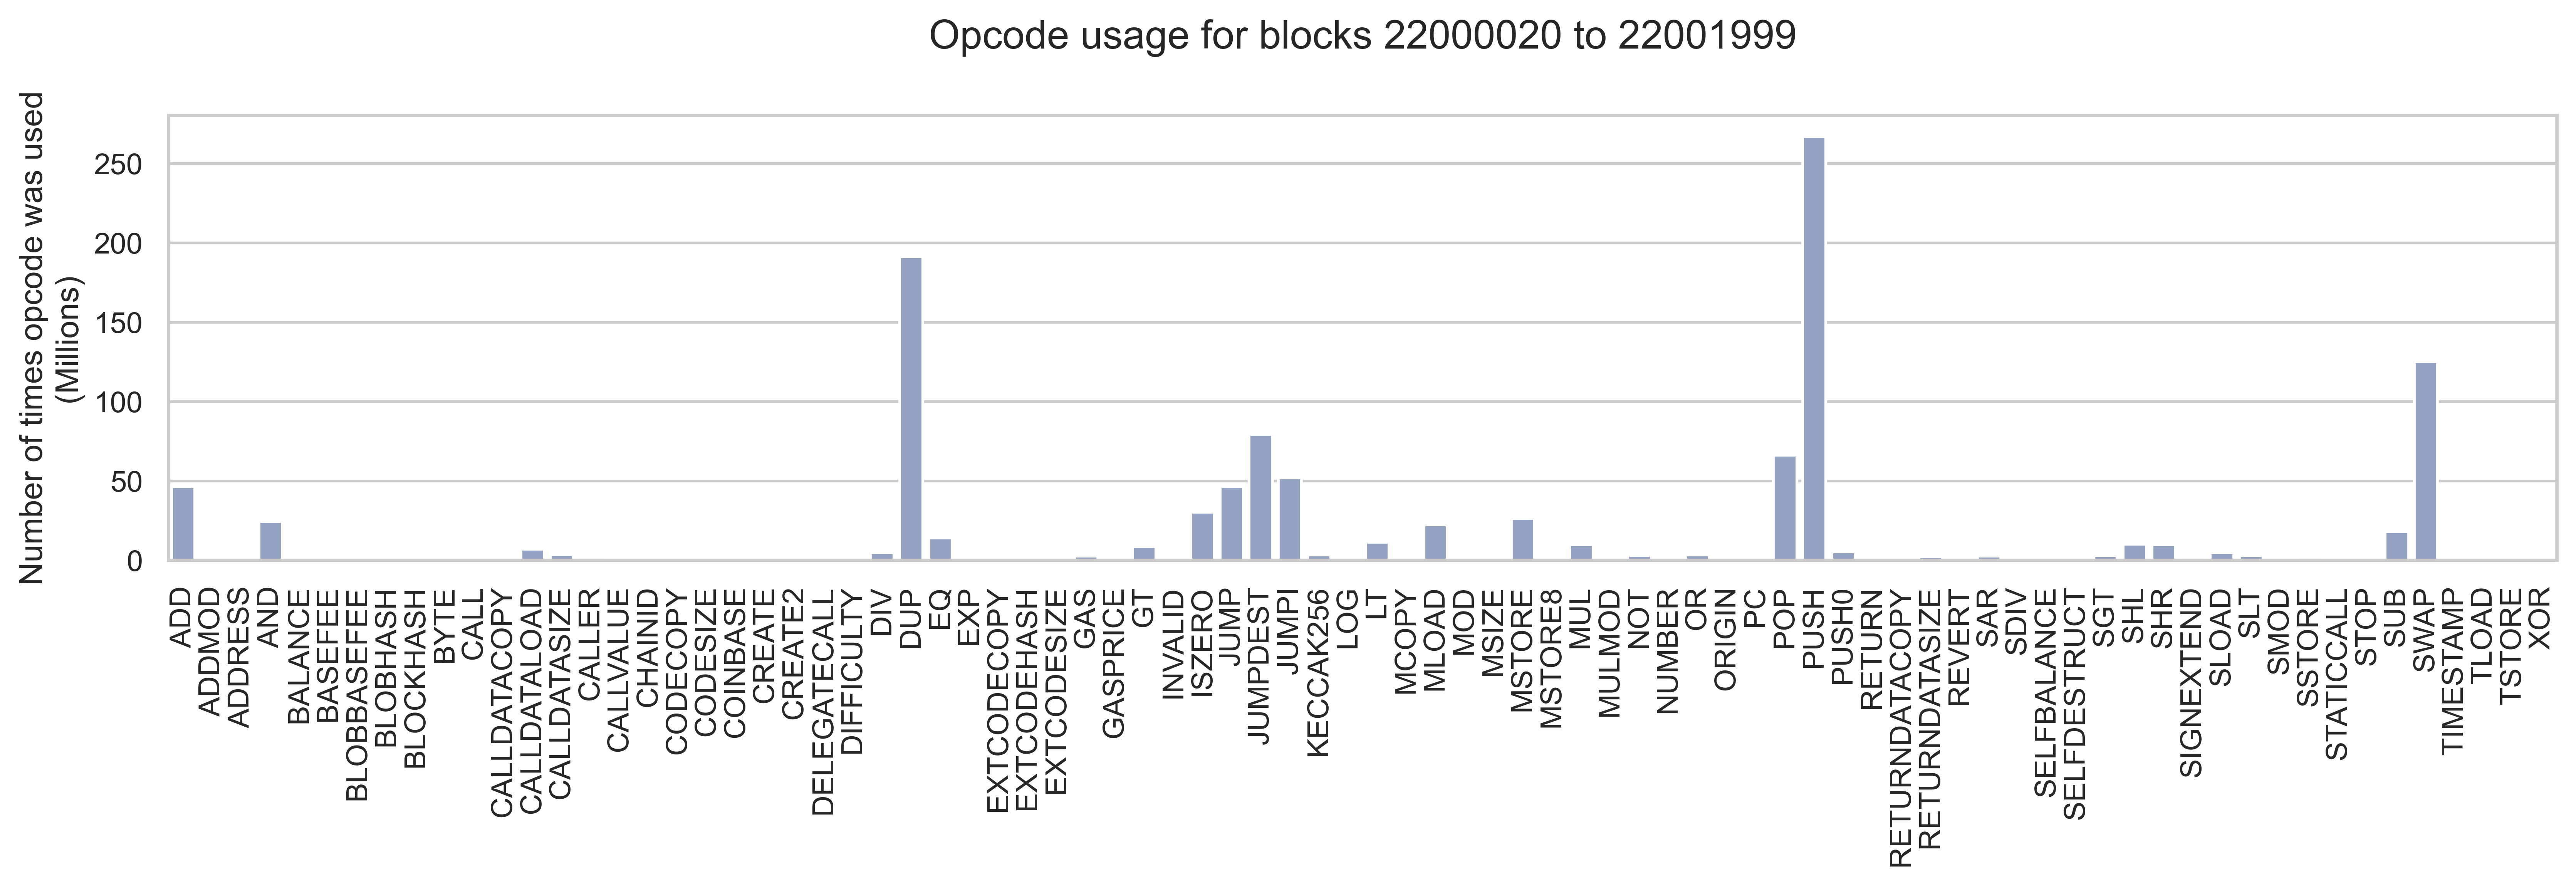

In [22]:
temp_df = filtered_usage_df.groupby("op")["op_gas_pair_count"].sum().reset_index()
temp_df["op_gas_pair_count"] = temp_df["op_gas_pair_count"] / 1_000_000
plt.figure(figsize=(16, 3))
sns.barplot(x="op", y="op_gas_pair_count", data=temp_df, color="#8da0cb")
plt.xticks(rotation=90)
plt.title("Opcode usage for blocks 22000020 to 22001999", pad=25)
plt.ylabel("Number of times opcode was used\n(Millions)")
plt.xlabel("")
plt.show()

In [23]:
temp_df = (
    filtered_usage_df.groupby("op")["op_gas_pair_count"]
    .sum()
    .reset_index()
    .sort_values("op_gas_pair_count", ascending=False)
    .head(15)
)
temp_df["op_gas_pair_count_perc"] = temp_df["op_gas_pair_count"]/temp_df["op_gas_pair_count"].sum()
temp_df

op  op_gas_pair_count  op_gas_pair_count_perc
56      PUSH          266979299                0.261615
25       DUP          191306233                0.187462
77      SWAP          125194311                0.122679
37  JUMPDEST           79217419                0.077626
55       POP           66249161                0.064918
38     JUMPI           51979758                0.050935
36      JUMP           46653474                0.045716
0        ADD           46294158                0.045364
35    ISZERO           30196885                0.029590
46    MSTORE           26520952                0.025988
3        AND           24452090                0.023961
43     MLOAD           22207913                0.021762
76       SUB           17926447                0.017566
26        EQ           13998465                0.013717
41        LT           11328925                0.011101

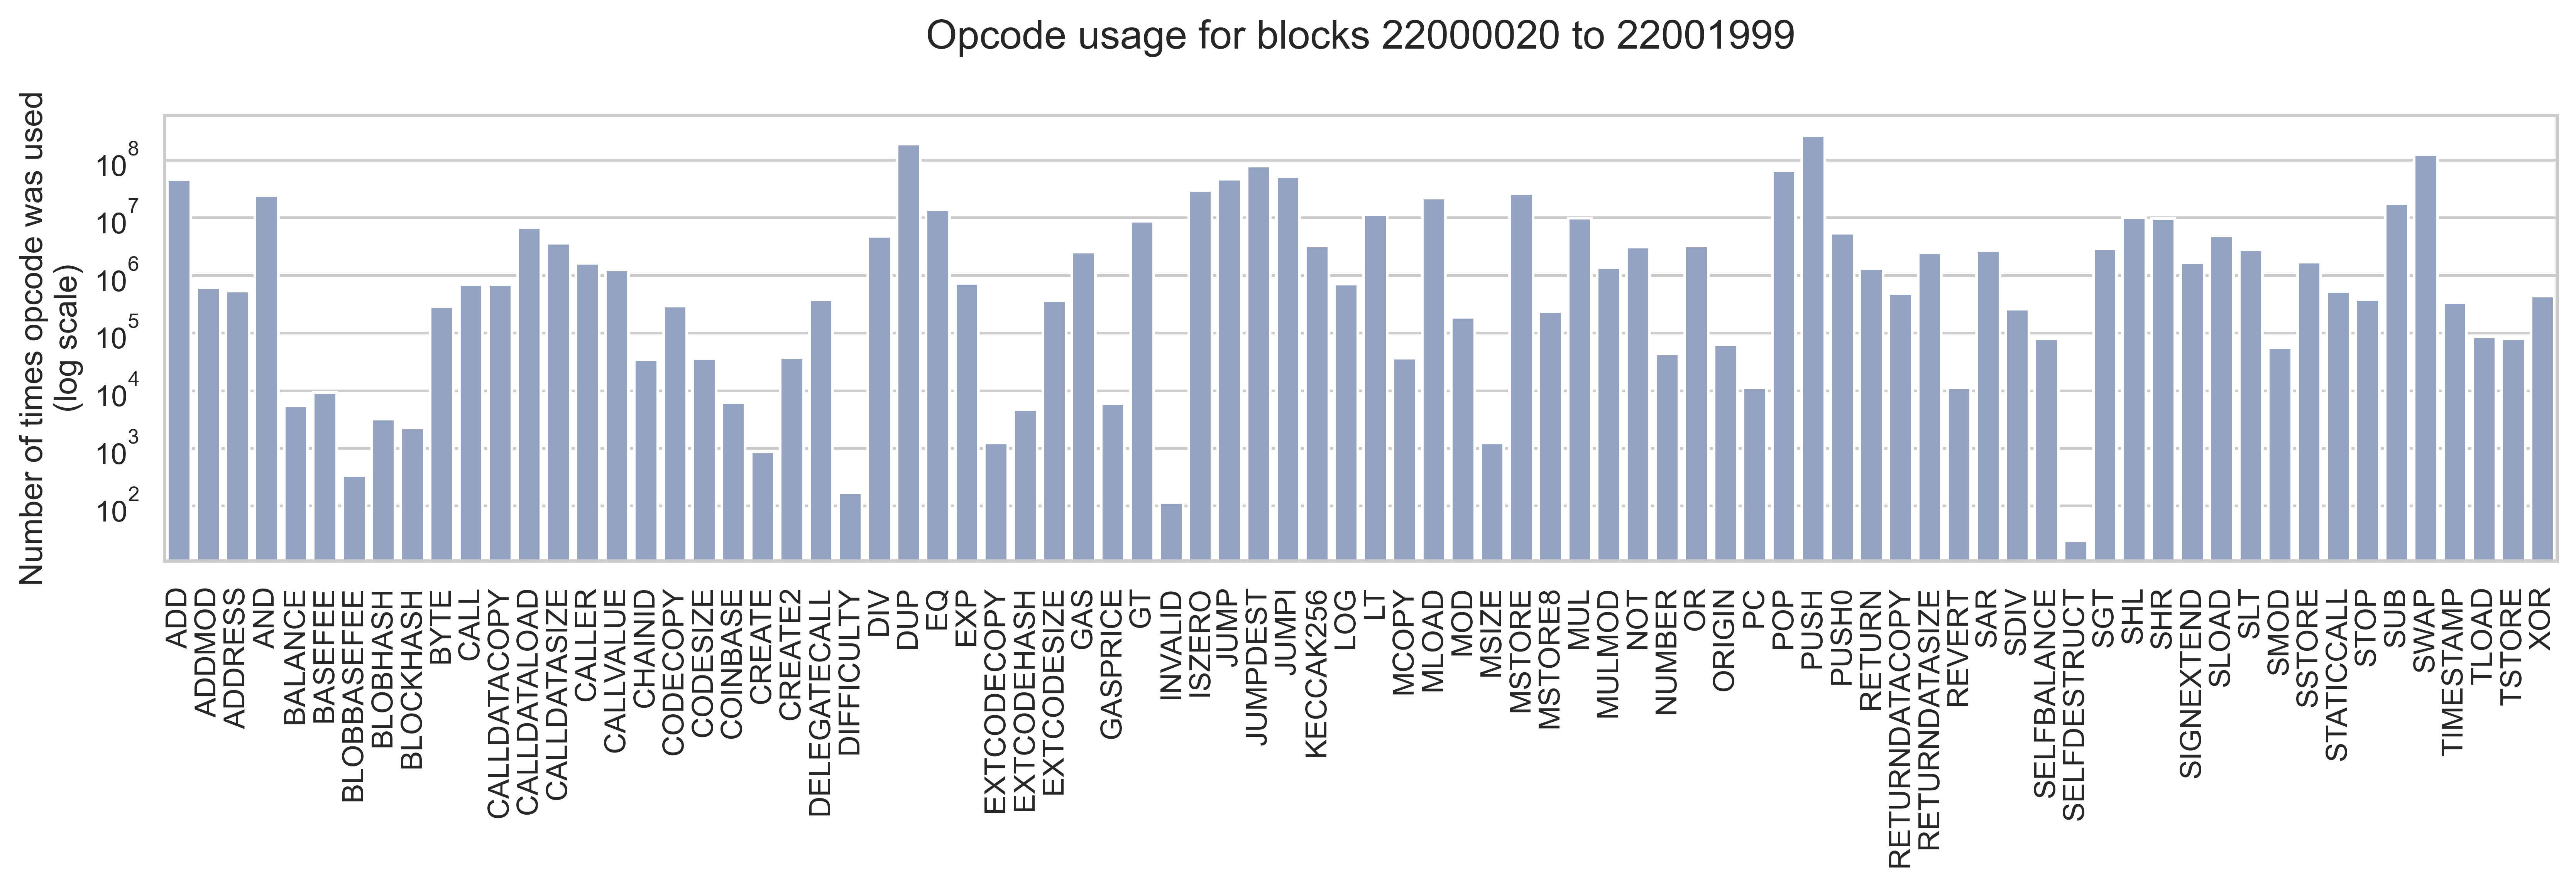

In [24]:
temp_df = filtered_usage_df.groupby("op")["op_gas_pair_count"].sum().reset_index()
temp_df["op_gas_pair_count"] = temp_df["op_gas_pair_count"]
plt.figure(figsize=(16, 3))
sns.barplot(x="op", y="op_gas_pair_count", data=temp_df, color="#8da0cb")
plt.xticks(rotation=90)
plt.yscale("log")
plt.title("Opcode usage for blocks 22000020 to 22001999", pad=25)
plt.ylabel("Number of times opcode was used\n(log scale)")
plt.xlabel("")
plt.show()

### Opcode gas usage

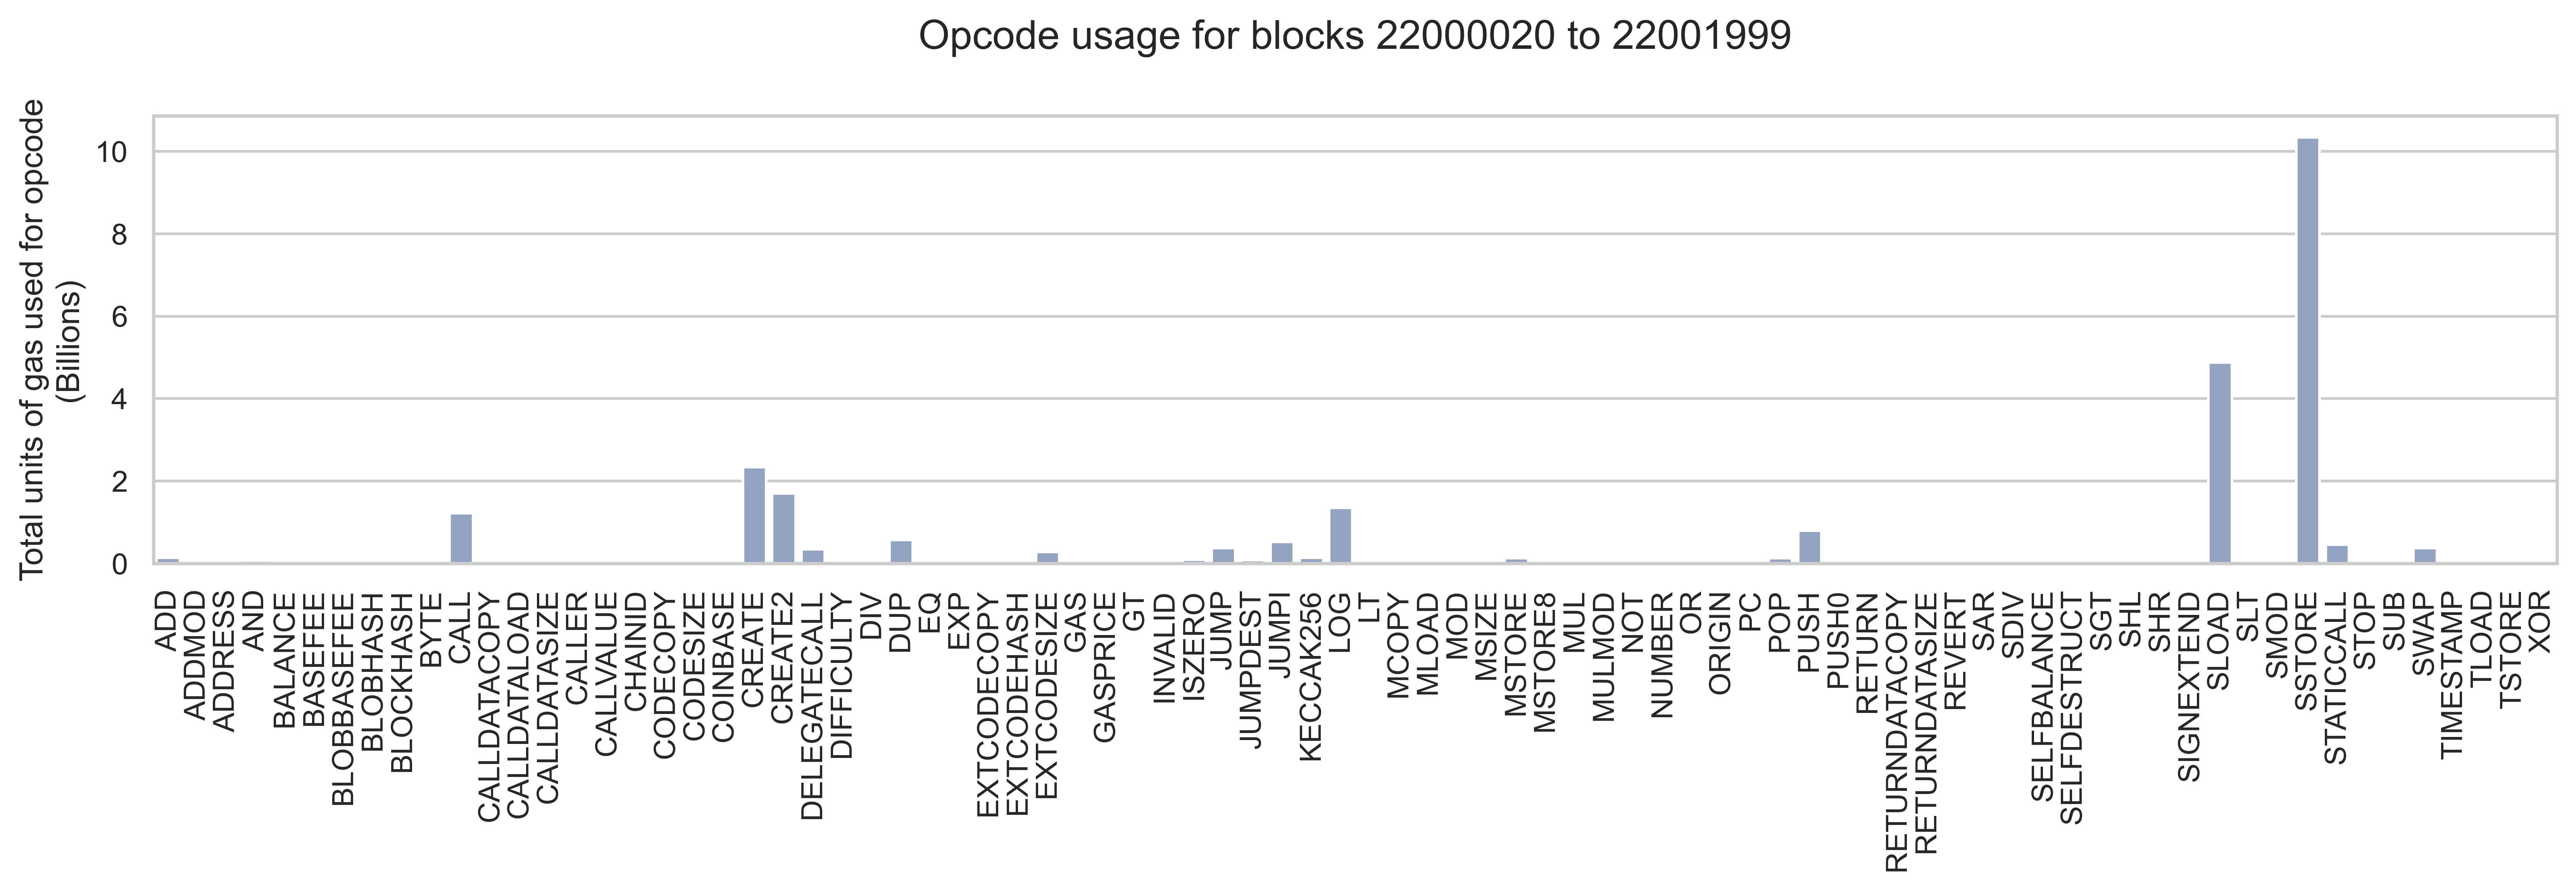

In [25]:
temp_df = filtered_usage_df.groupby("op")["op_total_gas_cost"].sum().reset_index()
temp_df["op_total_gas_cost"] = temp_df["op_total_gas_cost"] / 1_000_000_000
plt.figure(figsize=(16, 3))
sns.barplot(x="op", y="op_total_gas_cost", data=temp_df, color="#8da0cb")
plt.xticks(rotation=90)
plt.title("Opcode usage for blocks 22000020 to 22001999", pad=25)
plt.ylabel("Total units of gas used for opcode\n(Billions)")
plt.xlabel("")
plt.show()

In [26]:
temp_df = (
    filtered_usage_df.groupby("op")["op_total_gas_cost"]
    .sum()
    .reset_index()
    .sort_values("op_total_gas_cost", ascending=False)
    .head(15)
)
temp_df["op_total_gas_cost_perc"] = (
    temp_df["op_total_gas_cost"] / temp_df["op_total_gas_cost"].sum()
)
print(
    temp_df[temp_df["op"].isin(["DELEGATECALL", "STATICCALL", "CALL", "CALLCODE"])][
        "op_total_gas_cost"
    ].sum()
    / temp_df["op_total_gas_cost"].sum()
, "-- call-type cost")
temp_df

0.07866049343491537 -- call-type cost


op  op_total_gas_cost  op_total_gas_cost_perc
73        SSTORE       1.034199e+10                0.402435
70         SLOAD       4.878743e+09                0.189845
20        CREATE       2.339673e+09                0.091043
21       CREATE2       1.703989e+09                0.066307
40           LOG       1.353431e+09                0.052666
10          CALL       1.217516e+09                0.047377
56          PUSH       8.009379e+08                0.031167
25           DUP       5.739187e+08                0.022333
38         JUMPI       5.197976e+08                0.020227
74    STATICCALL       4.600328e+08                0.017901
77          SWAP       3.755829e+08                0.014615
36          JUMP       3.732278e+08                0.014523
22  DELEGATECALL       3.439099e+08                0.013382
30   EXTCODESIZE       2.762002e+08                0.010748
39     KECCAK256       1.395845e+08                0.005432

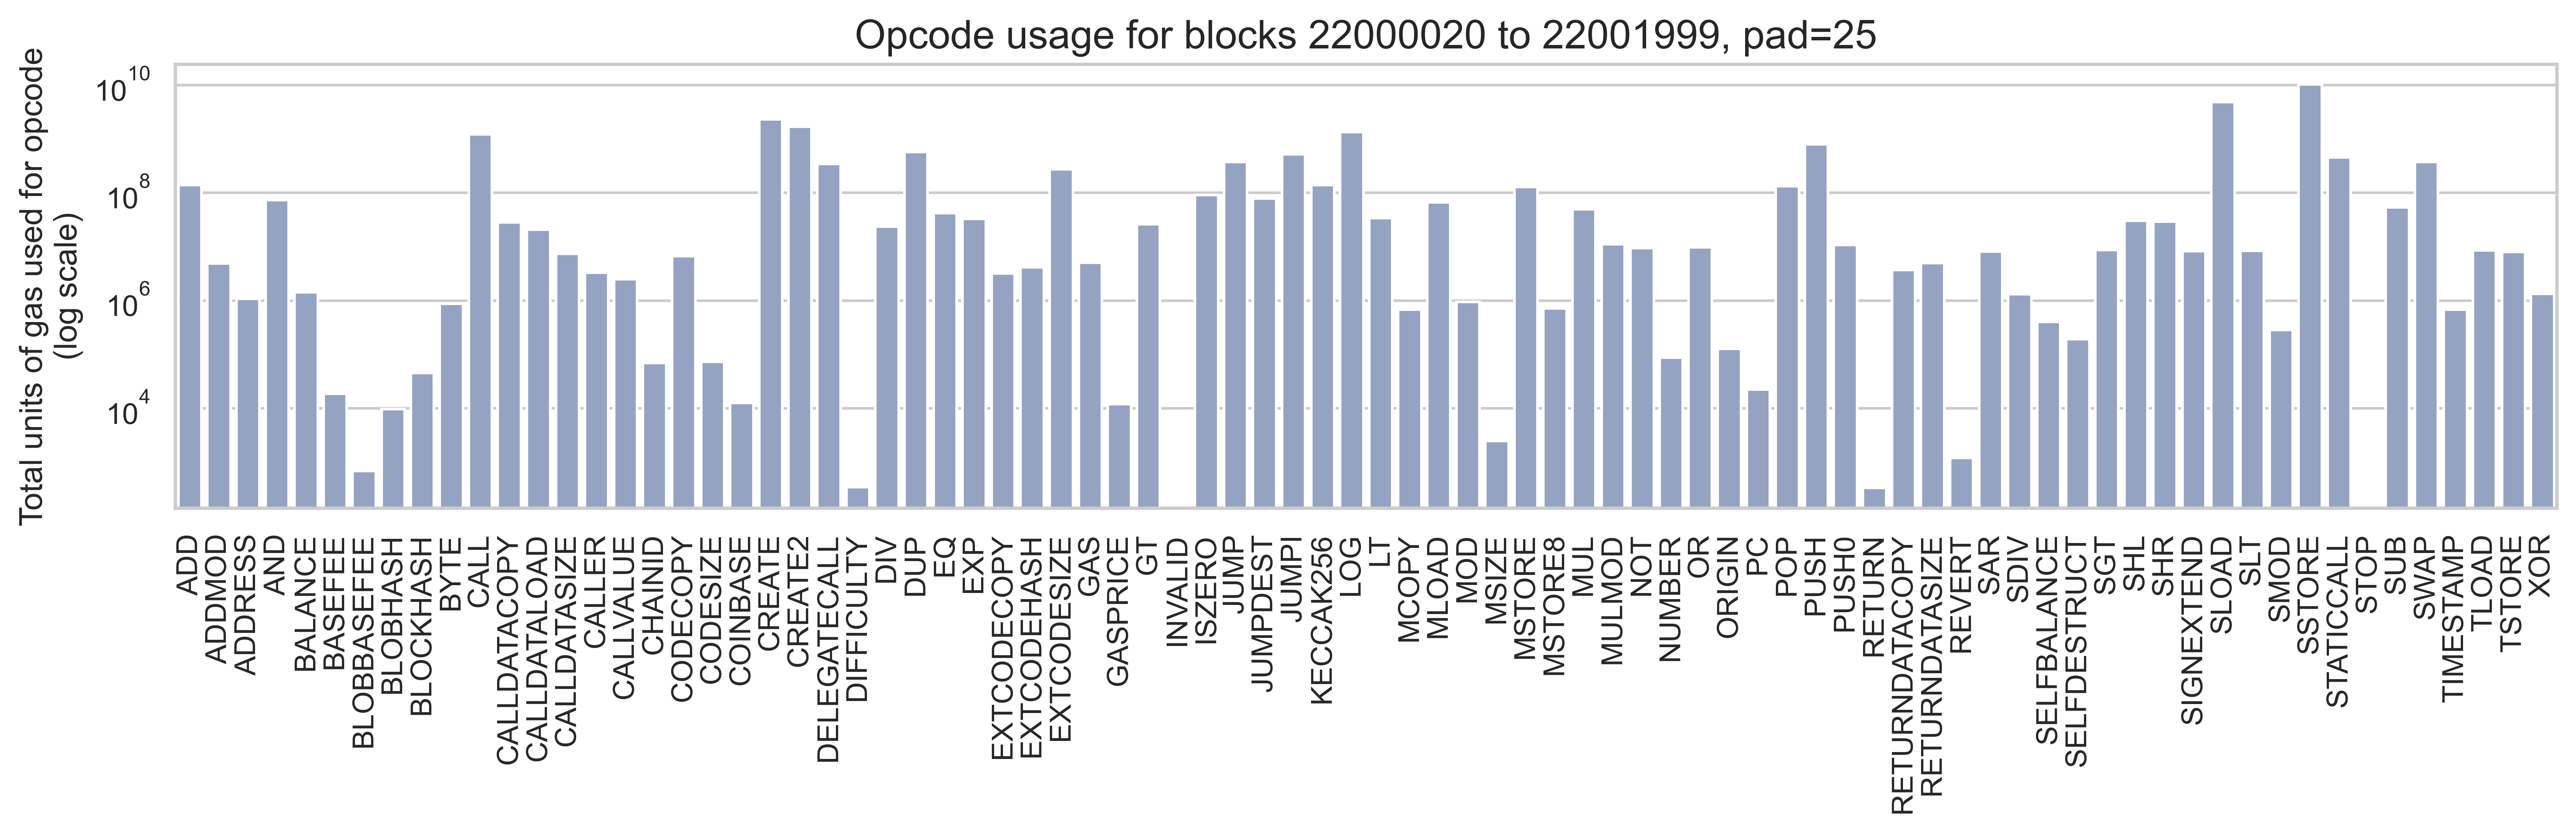

In [27]:
temp_df = filtered_usage_df.groupby("op")["op_total_gas_cost"].sum().reset_index()
temp_df["op_total_gas_cost"] = temp_df["op_total_gas_cost"]
plt.figure(figsize=(16, 3))
sns.barplot(x="op", y="op_total_gas_cost", data=temp_df, color="#8da0cb")
plt.xticks(rotation=90)
plt.yscale("log")
plt.title("Opcode usage for blocks 22000020 to 22001999, pad=25")
plt.ylabel("Total units of gas used for opcode\n(log scale)")
plt.xlabel("")
plt.show()

### Opcode usage correlation

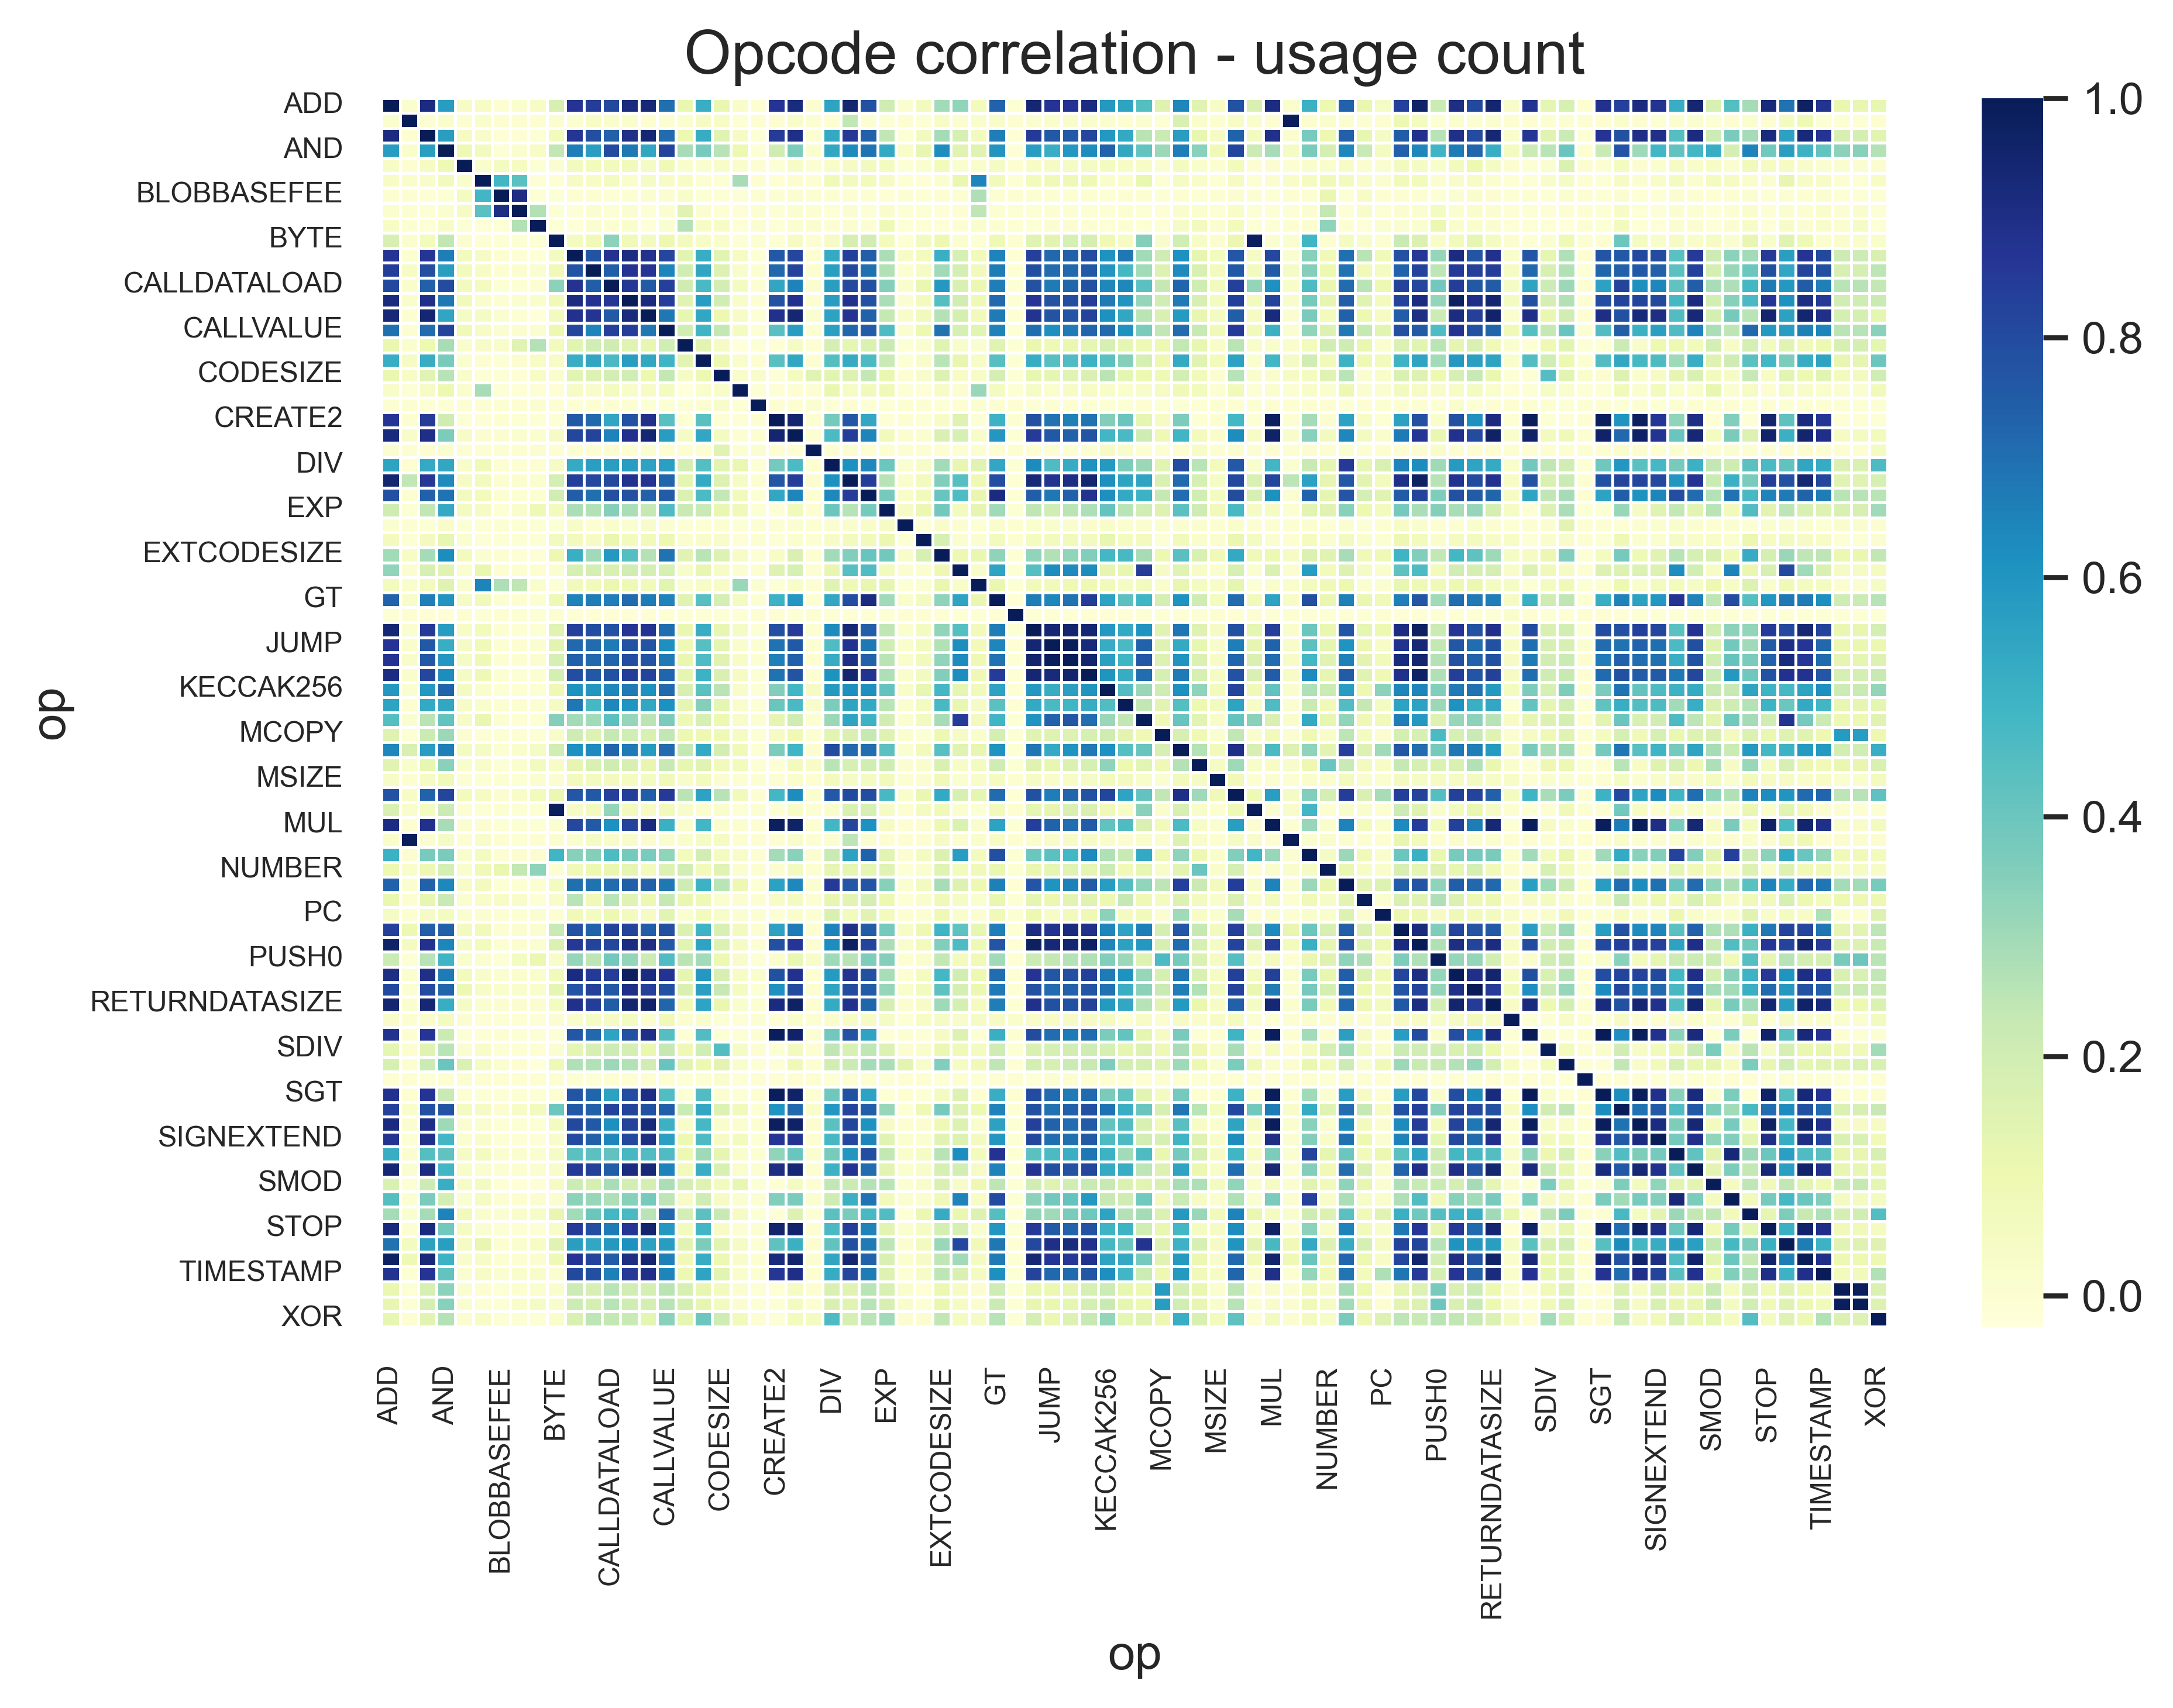

In [28]:
temp_df = pd.pivot_table(
    filtered_usage_df,
    values="op_gas_pair_count",
    index="tx_hash",
    columns="op",
    aggfunc="sum",
    fill_value=0.0,
)
corr_mat = temp_df.corr()
plt.figure(figsize=(8, 6))
ax = sns.heatmap(corr_mat, cmap="YlGnBu", linewidths=0.5)
plt.title("Opcode correlation - usage count")
ax.tick_params(axis="x", labelsize=7)
ax.tick_params(axis="y", labelsize=7)
plt.tight_layout()
plt.show()

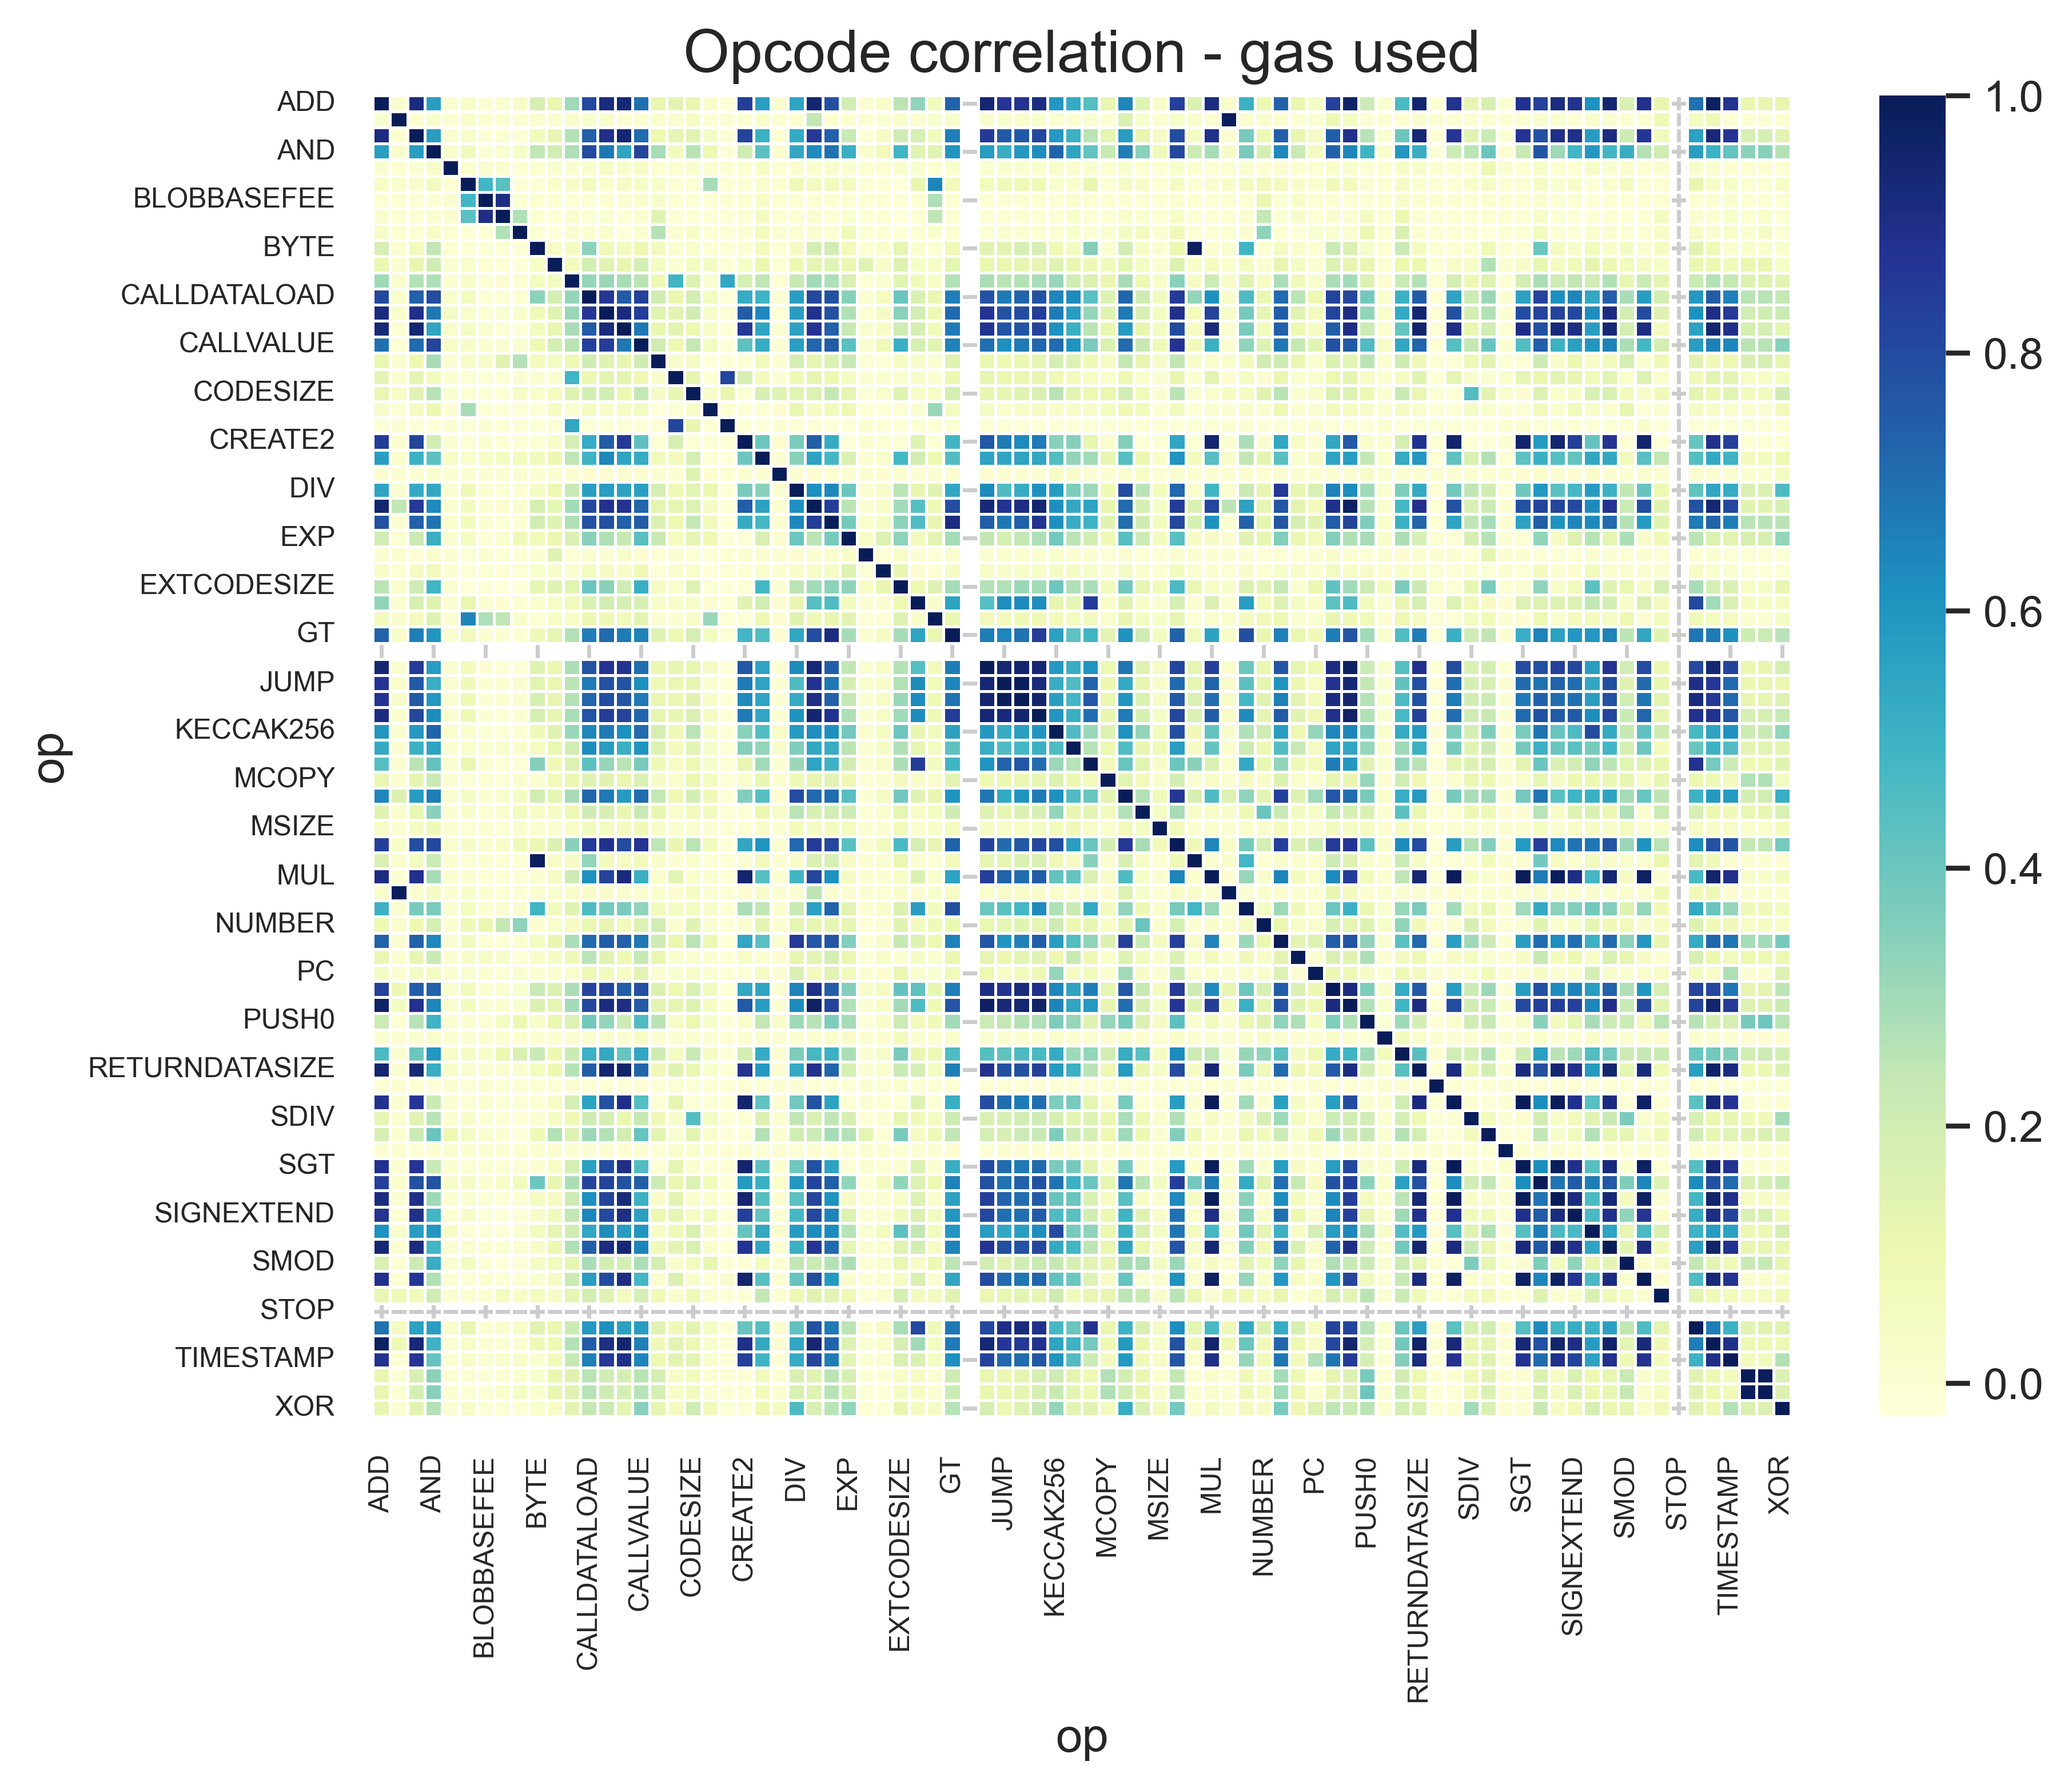

In [29]:
temp_df = pd.pivot_table(
    filtered_usage_df,
    values="op_total_gas_cost",
    index="tx_hash",
    columns="op",
    aggfunc="sum",
    fill_value=0.0,
)
corr_mat = temp_df.corr()
plt.figure(figsize=(8, 6))
ax = sns.heatmap(corr_mat, cmap="YlGnBu", linewidths=0.5)
plt.title("Opcode correlation - gas used")
ax.tick_params(axis="x", labelsize=7)
ax.tick_params(axis="y", labelsize=7)
plt.show()